# 📊 Restaurant Data Warehouse + ML Pipeline (Colab Ready)

This notebook lets you:
1. Build features + label (return in 30 days).
2. Train Decision Tree & Naive Bayes.
3. Evaluate with precision, recall, F1, accuracy, ROC-AUC.

---

### 📌 Note
All required packages are already pre-installed in Colab:
- pandas, numpy, scikit-learn, joblib, matplotlib, sqlalchemy

You can run the next cell directly.

In [7]:
# 📂 Load dataset directly from GitHub
import pandas as pd

url = "https://raw.githubusercontent.com/avinash972/restaurant-dw-ml/main/restaurant_orders.csv"
df_orders = pd.read_csv(url, parse_dates=['timestamp'])
print("Rows loaded:", len(df_orders))
df_orders.head()

Rows loaded: 2000


,order_id,customer_id,timestamp,total_amount,num_items,status,channel
0,1,CUST110,2024-11-18 22:34:00,1169.93,4,completed,delivery
1,2,CUST098,2024-04-06 11:47:00,875.42,7,completed,dine-in
2,3,CUST079,2024-09-10 14:32:00,1248.72,2,completed,dine-in
3,4,CUST040,2024-11-18 14:47:00,1323.64,1,completed,delivery
4,5,CUST093,2024-06-29 16:33:00,1361.23,7,completed,dine-in


In [8]:
# 🔧 Feature Engineering + Label Creation
import numpy as np

orders = df_orders.copy()
orders = orders.sort_values(['customer_id','timestamp']).reset_index(drop=True)

# Label
comp = orders[orders['status']=='completed'].sort_values(['customer_id','timestamp']).reset_index(drop=True)
comp['next_ts'] = comp.groupby('customer_id')['timestamp'].shift(-1)
comp['days_to_next'] = (comp['next_ts'] - comp['timestamp']).dt.days
comp['return_30d'] = ((comp['days_to_next'].notna()) & (comp['days_to_next'] <= 30)).astype(int)
label_map = comp.set_index('order_id')['return_30d'].to_dict()
orders['return_30d'] = orders['order_id'].map(label_map).fillna(0).astype(int)

# Features
orders['prev_ts'] = orders.groupby('customer_id')['timestamp'].shift(1)
orders['recency_days'] = (orders['timestamp'] - orders['prev_ts']).dt.days.fillna(999).astype(int)
orders['avg_ticket'] = orders['total_amount'] / orders['num_items'].replace(0,1)
orders['order_hour'] = orders['timestamp'].dt.hour
orders['is_weekend'] = orders['timestamp'].dt.dayofweek.isin([5,6]).astype(int)

# 90-day frequency
freq90 = []
for idx,row in orders.iterrows():
    cust = row['customer_id']; ts=row['timestamp']
    prior = orders[(orders['customer_id']==cust) & (orders['timestamp']<ts) & (orders['timestamp']>=ts-pd.Timedelta(days=90)) & (orders['status']=='completed')]
    freq90.append(len(prior))
orders['freq_90d'] = freq90

# Modeling dataset
model_df = orders[orders['status']=='completed'].copy()
print('Model dataset rows:', len(model_df))
model_df.head()

Model dataset rows: 1796


,order_id,customer_id,timestamp,total_amount,num_items,status,channel,return_30d,prev_ts,recency_days,avg_ticket,order_hour,is_weekend,freq_90d
0,1463,CUST001,2024-01-15 10:45:00,1259.29,7,completed,dine-in,1,NaT,999,179.898571,10,0,0
1,1761,CUST001,2024-01-21 15:55:00,793.07,5,completed,delivery,0,2024-01-15 10:45:00,6,158.614000,15,1,1
2,228,CUST001,2024-03-05 18:26:00,1475.97,3,completed,dine-in,1,2024-01-21 15:55:00,44,491.990000,18,0,2
3,1088,CUST001,2024-03-17 16:37:00,1379.80,1,completed,dine-in,1,2024-03-05 18:26:00,11,1379.800000,16,1,3
4,238,CUST001,2024-03-31 11:38:00,889.85,4,completed,takeaway,1,2024-03-17 16:37:00,13,222.462500,11,1,4


In [9]:
# 🤖 Train & Evaluate Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib, os

# Train/test split
split_date = pd.to_datetime('2024-07-01')
train = model_df[model_df['timestamp'] < split_date].copy()
test = model_df[model_df['timestamp'] >= split_date].copy()

feature_cols = ['total_amount','num_items','recency_days','avg_ticket','order_hour','is_weekend','freq_90d']
train = pd.get_dummies(train, columns=['channel'], drop_first=True)
test = pd.get_dummies(test, columns=['channel'], drop_first=True)
for c in ['channel_takeaway','channel_delivery']:
    if c not in train.columns: train[c]=0
    if c not in test.columns: test[c]=0
feature_cols += ['channel_takeaway','channel_delivery']

X_train, y_train = train[feature_cols].fillna(0), train['return_30d']
X_test, y_test = test[feature_cols].fillna(0), test['return_30d']

# Models
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)
nb = GaussianNB()

dt.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Predictions
y_dt, y_nb = dt.predict(X_test), nb.predict(X_test)
p_dt, p_nb = dt.predict_proba(X_test)[:,1], nb.predict_proba(X_test)[:,1]

def metrics(y_true,y_pred,y_proba):
    return dict(
        accuracy=round(accuracy_score(y_true,y_pred),3),
        precision=round(precision_score(y_true,y_pred,zero_division=0),3),
        recall=round(recall_score(y_true,y_pred,zero_division=0),3),
        f1=round(f1_score(y_true,y_pred,zero_division=0),3),
        roc_auc=round(roc_auc_score(y_true,y_proba) if len(set(y_true))>1 else float('nan'),3)
    )

print('Decision Tree:', metrics(y_test,y_dt,p_dt))
print('Naive Bayes:', metrics(y_test,y_nb,p_nb))

print('\nClassification Report (Decision Tree):\n', classification_report(y_test,y_dt,zero_division=0))
print('\nClassification Report (Naive Bayes):\n', classification_report(y_test,y_nb,zero_division=0))

# Save artifacts
os.makedirs('outputs', exist_ok=True)
joblib.dump(dt, 'outputs/decision_tree.joblib')
joblib.dump(nb, 'outputs/naive_bayes.joblib')
model_df.to_csv('outputs/model_dataset.csv', index=False)
print('Artifacts saved in outputs/')

Decision Tree: {'accuracy': 0.65, 'precision': 0.659, 'recall': 0.976, 'f1': 0.787, 'roc_auc': np.float64(0.506)}
Naive Bayes: {'accuracy': 0.658, 'precision': 0.661, 'recall': 0.991, 'f1': 0.793, 'roc_auc': np.float64(0.487)}

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.22      0.01      0.03       295
           1       0.66      0.98      0.79       576

    accuracy                           0.65       871
   macro avg       0.44      0.49      0.41       871
weighted avg       0.51      0.65      0.53       871


Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.29      0.01      0.01       295
           1       0.66      0.99      0.79       576

    accuracy                           0.66       871
   macro avg       0.47      0.50      0.40       871
weighted avg       0.53      0.66      0.53       871

Artifacts saved in outputs/


In [10]:
# 📊 Step 1: Extract metrics into variables for plotting
dt_acc  = accuracy_score(y_test, y_dt)
dt_prec = precision_score(y_test, y_dt, zero_division=0)
dt_rec  = recall_score(y_test, y_dt, zero_division=0)
dt_f1   = f1_score(y_test, y_dt, zero_division=0)
dt_roc  = roc_auc_score(y_test, p_dt)

nb_acc  = accuracy_score(y_test, y_nb)
nb_prec = precision_score(y_test, y_nb, zero_division=0)
nb_rec  = recall_score(y_test, y_nb, zero_division=0)
nb_f1   = f1_score(y_test, y_nb, zero_division=0)
nb_roc  = roc_auc_score(y_test, p_nb)

print("✅ Metrics saved for plotting")

✅ Metrics saved for plotting


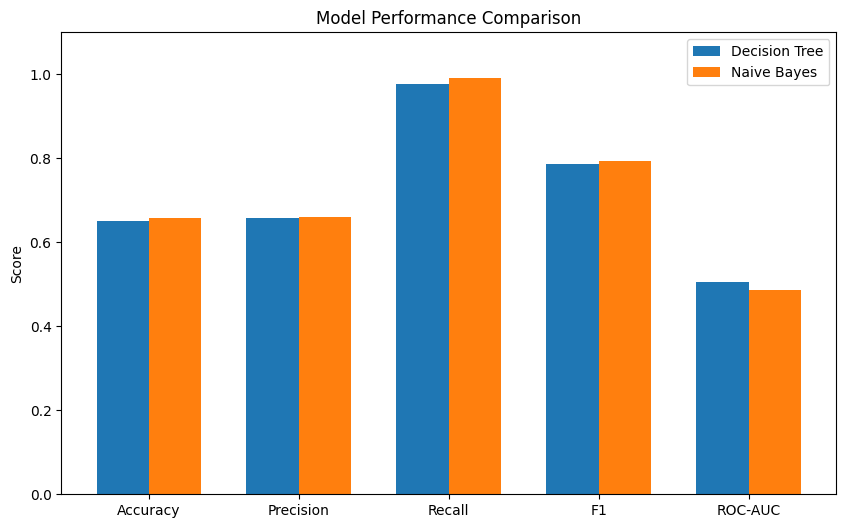

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Collect metrics
models = ["Decision Tree", "Naive Bayes"]
metrics_names = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
dt_scores = [dt_acc, dt_prec, dt_rec, dt_f1, dt_roc]
nb_scores = [nb_acc, nb_prec, nb_rec, nb_f1, nb_roc]

# Plot grouped bar chart
x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, dt_scores, width, label="Decision Tree")
plt.bar(x + width/2, nb_scores, width, label="Naive Bayes")

plt.xticks(x, metrics_names)
plt.ylabel("Score")
plt.ylim(0,1.1)
plt.title("Model Performance Comparison")
plt.legend()
plt.show()


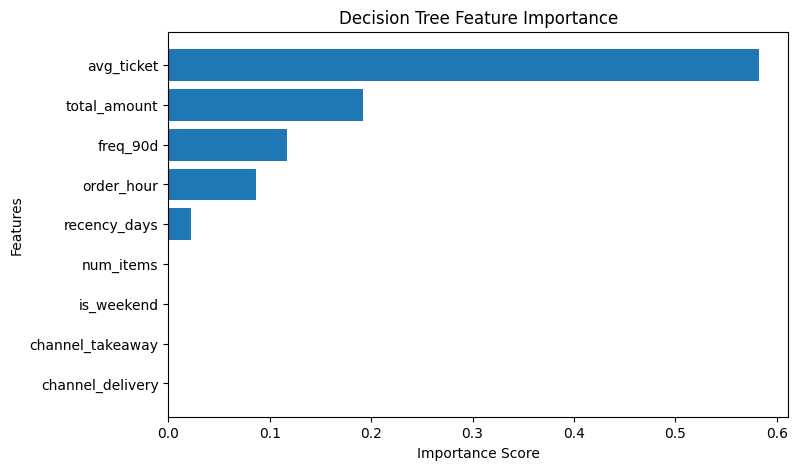

,Feature,Importance
3,avg_ticket,0.582180
0,total_amount,0.191788
6,freq_90d,0.117121
4,order_hour,0.086160
2,recency_days,0.022751
1,num_items,0.000000
5,is_weekend,0.000000
7,channel_takeaway,0.000000
8,channel_delivery,0.000000


In [13]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": dt.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Decision Tree Feature Importance")
plt.gca().invert_yaxis()
plt.show()

importance_df
